In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import display, clear_output
from datetime import datetime, timedelta
import geopandas
from time import sleep

In [2]:
def date_converter(b):
    return datetime.strptime(b.decode('utf-8'), '%Y-%m-%d %H:%M:%S')

# Load the CSV file with mixed data types
results = np.genfromtxt('brown_pelican_mortality.csv', delimiter=',', dtype=None, names=True, converters={'DateColumnName': date_converter})

C:\Users\kyans\AppData\Local\Temp\ipykernel_2232\421559811.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  results = np.genfromtxt('brown_pelican_mortality.csv', delimiter=',', dtype=None, names=True, converters={'DateColumnName': date_converter})


In [3]:
results.dtype

dtype([('time_observed_at', 'S23'), ('latitude', '<f8'), ('longitude', '<f8')])

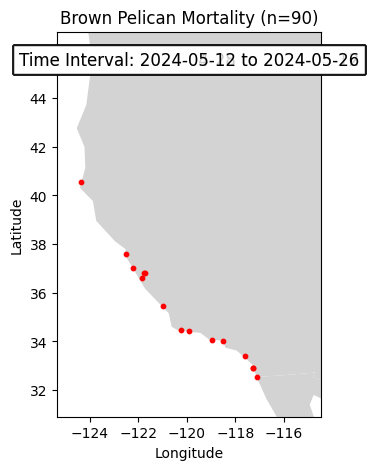

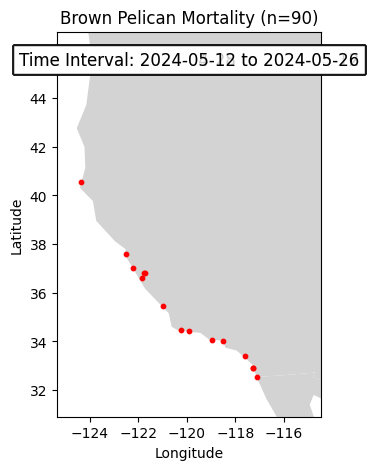

In [4]:
# Define the time interval for each bucket (in seconds)
bucket_interval = timedelta(days=14)  # Change this as needed

# Extract latitudes, longitudes, and datetimes
lats = results['latitude']
lons = results['longitude']
datetimes = results['time_observed_at']

# Convert datetime strings to datetime objects
datetimes = np.array([datetime.strptime(dt.decode('utf-8'), '%Y-%m-%d %H:%M:%S UTC') for dt in datetimes])

# Determine the minimum and maximum datetimes
min_datetime = min(datetimes)
max_datetime = max(datetimes)

# Create a GeoDataFrame for plotting the world map
worldmap = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 5))
worldmap.plot(color="lightgrey", ax=ax)
scatter = ax.scatter([], [], 10, marker='o', color='Red')

# Setting axis limits
bound = 1
ax.set_ylim([min(lats) - bound, max(lats) + bound])
ax.set_xlim([min(lons) - bound, max(lons) + bound])

# Add title and axis labels
ax.set_title("Brown Pelican Mortality (n=90)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Define function to filter points within a time bucket
def filter_points_in_bucket(start_time, end_time):
    return np.array([(lon, lat) for lon, lat, dt in zip(lons, lats, datetimes) if start_time <= dt <= end_time])

# Update function for animation
def update(frame):
    # Calculate start and end time for the current bucket
    start_time = min_datetime + frame * bucket_interval
    end_time = min_datetime + (frame + 1) * bucket_interval
    
    # Filter points within the current bucket
    points_in_bucket = filter_points_in_bucket(start_time, end_time)
    
    if len(points_in_bucket) == 0:
        scatter.set_offsets(np.empty((0, 2)))  # Set offsets to empty array if no points found
    else:
        # Update scatter plot with points in the bucket
        scatter.set_offsets(points_in_bucket)
    
    # Add text annotation for the time interval
    ax.text(0.5, 0.95, f'Time Interval: {start_time.strftime("%Y-%m-%d")} to {end_time.strftime("%Y-%m-%d")}', transform=ax.transAxes,
            ha="center", va="top", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    return scatter,

# Creating the animation
num_buckets = int((max_datetime - min_datetime).total_seconds() / bucket_interval.total_seconds())
ani = animation.FuncAnimation(fig, update, frames=num_buckets, interval=1000, blit=True, repeat=False)  # Adjust interval for animation speed

# Animation loop
for i in range(num_buckets + 1):
    update(i)
    clear_output(wait=True)
    display(fig)
    sleep(1)
